In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from itertools import combinations_with_replacement
from functools import reduce
from operator import mul
from math import factorial
import einops
from koopman.simulation.simulator import simulate, simulate_batch
from koopman.simulation.systems import DynamicalSystem, VanDerPolOscillator
from koopman.edmd.edmd import eDMD
from koopman.simulation.simulator import rk4_step

from sklearn.preprocessing import PolynomialFeatures
from numpy.polynomial.chebyshev import Chebyshev
from spatialmath.base import angle_wrap
from scipy.ndimage import gaussian_filter1d

def get_random_visible_color():
    # Sample hue randomly, fix saturation and value for vibrancy
    h = np.random.rand()           # Hue ∈ [0, 1]
    s = np.random.uniform(0.6, 1)  # Saturation: avoid pale colors
    v = np.random.uniform(0.7, 1)  # Value (brightness): avoid dark
    return mcolors.hsv_to_rgb((h, s, v))

In [2]:
# Run a simulation with the Van Der Pol system
vanderpol = VanDerPolOscillator(VanDerPolOscillator.Params(mu=1.0))

N = 500
x0 = np.random.uniform(-3, 3, (N, 2))
tf = 10.0
dt = 0.1
T = int(tf/dt)
# controls = np.random.randn(N, T, 1) * 5.0
controls = np.zeros((N, T, 1)) #np.random.randn(N, T, 1) * 5.0

ts, xhist, uhist = simulate_batch(
    sys=vanderpol,
    tf=tf,
    dt=dt,
    u=controls,
    x0=x0
)

print(f"Simulation finished. {xhist.shape=}, {uhist.shape=}")

Simulation progress: 100%|██████████| 100/100 [00:00<00:00, 10412.61it/s]

Simulation finished. xhist.shape=(500, 101, 2), uhist.shape=(500, 100, 1)


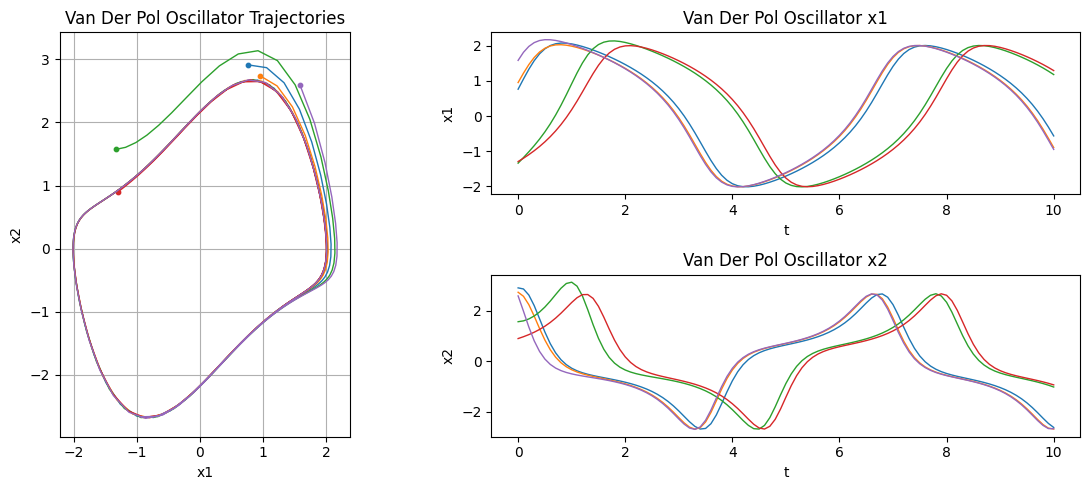

In [3]:
trajectory_samples = xhist[np.random.randint(0, N, 5), :, :]

# Plot the trajectory
fig = plt.figure(figsize=(12, 5))
gs = fig.add_gridspec(2, 2, width_ratios=[1, 1])

ax_traj = fig.add_subplot(fig.add_subplot(gs[:, 0]))
ax_x1 = fig.add_subplot(gs[0, 1])
ax_x2 = fig.add_subplot(gs[1, 1])

for i in range(trajectory_samples.shape[0]):
    x = ax_traj.plot(trajectory_samples[i, :, 0], trajectory_samples[i, :, 1], linewidth=1)
    _ = ax_traj.scatter(trajectory_samples[i, 0, 0], trajectory_samples[i, 0, 1], color=x[0].get_color(), s=10)
    
    _ = ax_x1.plot(ts, trajectory_samples[i, :, 0], linewidth=1)
    _ = ax_x2.plot(ts, trajectory_samples[i, :, 1], linewidth=1)

ax_traj.set_title("Van Der Pol Oscillator Trajectories")
ax_traj.set_xlabel("x1")
ax_traj.set_ylabel("x2")
ax_traj.grid()
ax_traj.set_aspect('equal', adjustable='box')

ax_x1.set_title("Van Der Pol Oscillator x1")
ax_x1.set_xlabel("t")
ax_x1.set_ylabel("x1")

ax_x2.set_title("Van Der Pol Oscillator x2")
ax_x2.set_xlabel("t")
ax_x2.set_ylabel("x2")

plt.tight_layout()
plt.show()

In [ ]:
# Hand-pick the observables
def generate_thin_plate_rbf(nx, n_centers=100):
    centers = np.random.uniform(-3, 3, (n_centers, nx))
    
    def evaluate(X):
        # Compute the radial basis function values
        dists = np.linalg.norm(X[:, None, :] - centers[None, :, :], axis=-1)  # shape: (B, num_centers)
        with np.errstate(divide='ignore', invalid='ignore'):
            rbf = dists**2 * np.log(dists)
            rbf[np.isnan(rbf)] = 0.0  # set r=0 cases to 0
        
        return rbf
    
    return evaluate

rbf_generator = generate_thin_plate_rbf(nx=VanDerPolOscillator.nx, n_centers=50)

def koopman_observables(xhist: np.ndarray) -> np.ndarray:
    is_batched = xhist.ndim == 2
    if not is_batched:
        xhist = np.expand_dims(xhist, axis=0)
    
    Y1 = rbf_generator(xhist)  # shape(B, num_centers)
    
    null_controls = np.zeros((xhist.shape[0], VanDerPolOscillator.nu))
    step1 = rk4_step(vanderpol.dynamics,
                     xhist,
                     null_controls,
                     dt)
    step2 = rk4_step(vanderpol.dynamics,
                     step1,
                     null_controls,
                     dt)
    step3 = rk4_step(vanderpol.dynamics,
                     step2,
                     null_controls,
                     dt)
    step4 = rk4_step(vanderpol.dynamics,
                     step3,
                     null_controls,
                     dt)
        
    out = np.concatenate([xhist,
                          Y1,
                          step1,
                          step2,
                          step3,
                          step4], axis=-1)
    
    if not is_batched:
        return np.squeeze(out, axis=0)
    else:
        return out

# Fit the eDMD model to the data using the observable
edmd = eDMD(nx=VanDerPolOscillator.nx, nu=VanDerPolOscillator.nu, bilinear=False)
zhist = edmd.apply_observable_to_history(xhist, koopman_observables)
_ = edmd.fit(zhist, uhist)

Fitting EDMD model with data:
	zhist.shape=(500, 101, 60)
	uhist.shape=(500, 100, 1)
	# of trajectories: 500
	# of time steps: 101
	# of lifted states: 60
	# of controls: 1
Fitting results:
	self.kpA.shape=(60, 60)
	self.kpB.shape=(60, 1)
	A condition number: 920371824435.7959
	B condition number: inf
	Residual: 1.9233803315503144e-11


In [5]:
# Evaluate the model on some new data
x0 = np.random.uniform(-3, 3, 2)
# x0 = np.array([0.1, -2])

ts = np.arange(0, tf, dt)
controls = np.zeros((T, 1))

eval_ts, eval_xhist, eval_uhist = simulate(
    sys=vanderpol,
    tf=tf,
    dt=dt,
    u=controls,
    x0=x0
)

# Simulate the system with the learned model
zjm1 = koopman_observables(x0)

eval_xhist_pred = np.empty_like(eval_xhist)
eval_xhist_pred[0] = edmd.project_to_x(zjm1)

for i, t in enumerate(eval_ts[:-1]):
    zj = edmd.predict_z_next(zjm1, controls[i])
    eval_xhist_pred[i + 1] = edmd.project_to_x(zj)
    
    zjm1 = zj

Simulation progress: 100%|██████████| 100/100 [00:00<00:00, 11501.01it/s]


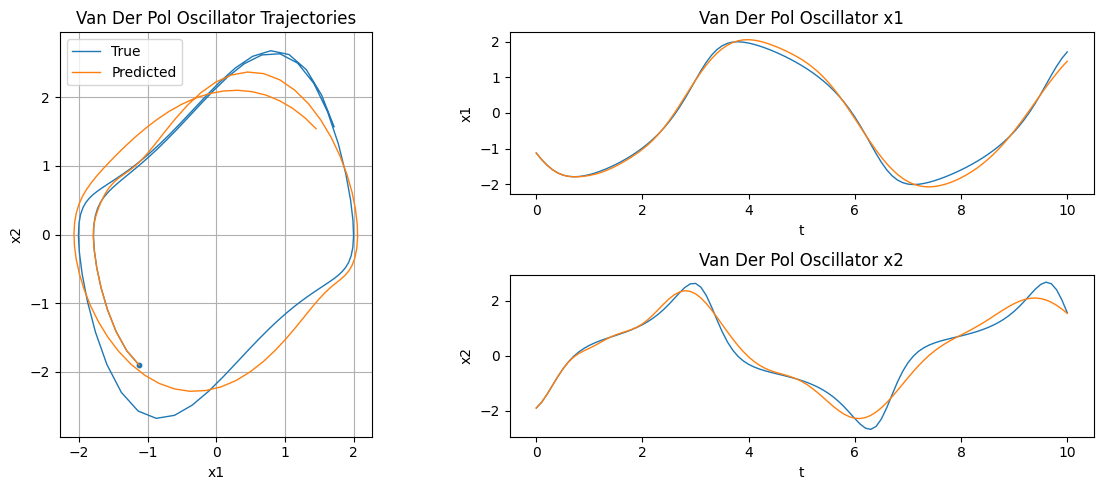

In [6]:
# Plot the trajectory
fig = plt.figure(figsize=(12, 5))
gs = fig.add_gridspec(2, 2, width_ratios=[1, 1])

ax_traj = fig.add_subplot(fig.add_subplot(gs[:, 0]))
ax_x1 = fig.add_subplot(gs[0, 1])
ax_x2 = fig.add_subplot(gs[1, 1])

x = ax_traj.plot(eval_xhist[:, 0], eval_xhist[:, 1], linewidth=1, label="True")
_ = ax_traj.plot(eval_xhist_pred[:, 0], eval_xhist_pred[:, 1], linewidth=1, label="Predicted")
ax_traj.scatter(eval_xhist[0, 0], eval_xhist[0, 1], color=x[0].get_color(), s=10)
ax_traj.set_title("Van Der Pol Oscillator Trajectories")
ax_traj.set_xlabel("x1")
ax_traj.set_ylabel("x2")
ax_traj.grid()
ax_traj.legend()
ax_traj.set_aspect('equal', adjustable='box')

ax_x1.plot(eval_ts, eval_xhist[:, 0], linewidth=1, label="True")
ax_x1.plot(eval_ts, eval_xhist_pred[:, 0], linewidth=1, label="Predicted")
ax_x1.set_title("Van Der Pol Oscillator x1")
ax_x1.set_xlabel("t")
ax_x1.set_ylabel("x1")

ax_x2.plot(eval_ts, eval_xhist[:, 1], linewidth=1, label="True")
ax_x2.plot(eval_ts, eval_xhist_pred[:, 1], linewidth=1, label="Predicted")
ax_x2.set_title("Van Der Pol Oscillator x2")
ax_x2.set_xlabel("t")
ax_x2.set_ylabel("x2")

plt.tight_layout()
plt.show()